# PMT single photon test & baseline test

- test baseline with 0.6V, 1.2V, 1.8V, 2.4V
- test single photon signal

### Packages

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from scipy.special import factorial
from scipy.optimize import leastsq, curve_fit, basinhopping
import math
from functools import partial
from collections import Counter

### Plot Single signal / Average Signal

##### Plot Tools

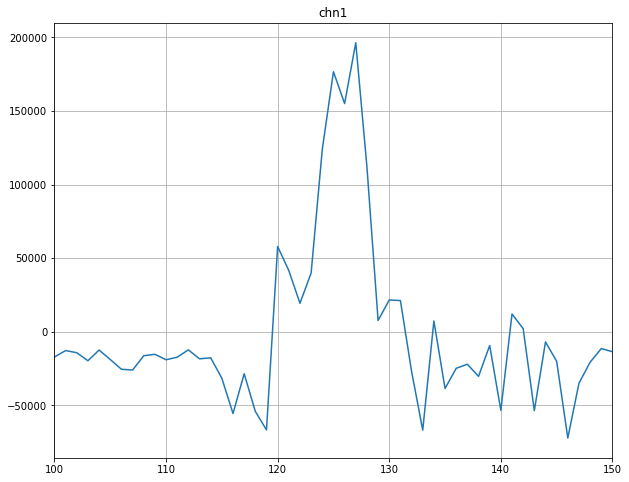

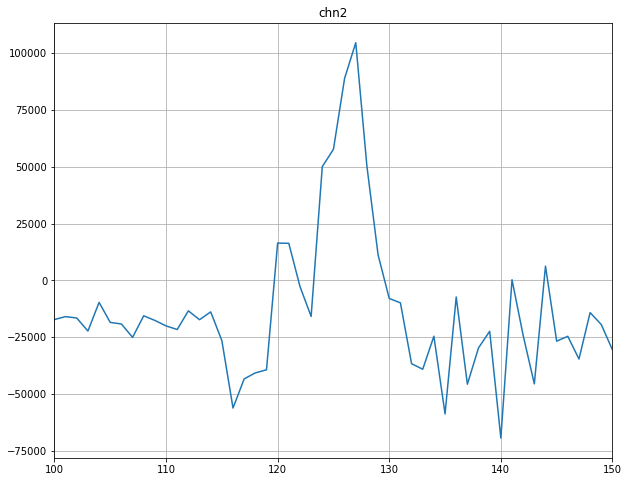

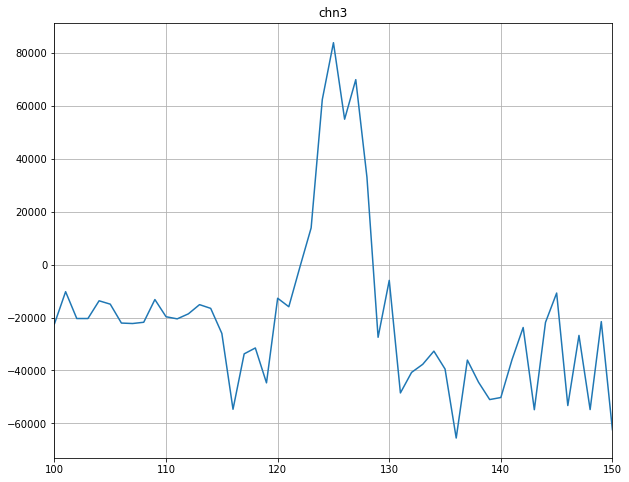

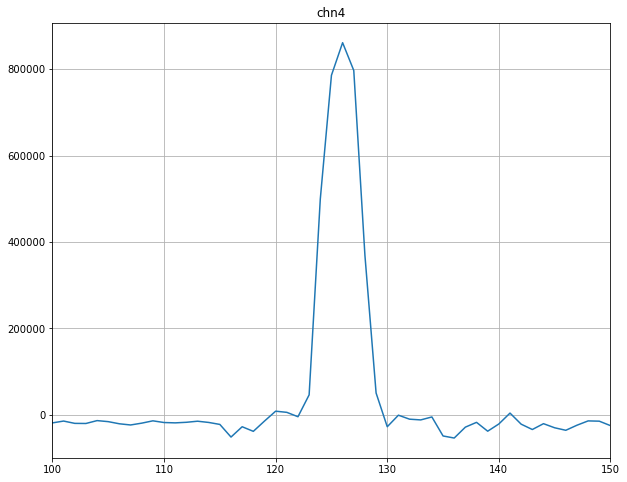

In [61]:
# tools for analysis
def get_bits(data: bytes, bit: int = 0):
    return int.from_bytes(bytes=data, byteorder='little') & ((1 << bit + 1) - 1)

def to_int(data: bytes):
    return int.from_bytes(bytes=data, byteorder='little')

def get_chn(data: int):
    data_len = len(bin(data))-2
    return [i for i in range(data_len) if data & (1 << i)]

def plt_signal_set(title: str):
    plt.title(title)
    plt.xlabel('sample')
    plt.ylabel('Voltage / mV')
    plt.grid()


def plt_signal(file: str, count: int = 0, title: str = '', chn_list = range(16), raw = True):
    plt_legend = []
    chn_count = Counter()
    with open(file , mode='rb') as f:
        ev_count = 0
        while (True):
            ev_header = f.read(4 << 2)
            if (len(ev_header) == 0):
                break
            ## VALIDATE EVENT 
            ev_check = ev_header[3] >> 4 
            if (ev_check != 10):
                break
            ## GET EVENT SIZE
            ev_size = get_bits(ev_header[:4], 27)
            ## GET BOARD EVENT COUNT
            ev_count = to_int(ev_header[8:11])
            ## GET CHANNEL MASK
            ev_chn_mask = get_chn(ev_header[4])
            ## INIT CHANNEL CHECK
            chn_check = 0
            while(len(ev_chn_mask)):
                chn_header = f.read(3 << 2)
                ## GET CHANNEL SIZE
                chn_size = get_bits(chn_header[:3], 22) 
                chn_id = ev_chn_mask.pop(0)
                chn_count[chn_id] += 1
                if not (chn_id in chn_list and count + 1 == chn_count[chn_id])  :
                    f.seek((chn_size - 3) << 2, 1)
                    continue
                # chn_check = chn_check | (1 << chn_id)
                chn_base = to_int(chn_header[-2:])
                ## GET SIGNAL LIST
                raw_data = f.read((chn_size - 3) << 2)
                sig_list = ( (0 if raw else chn_base) - np.frombuffer(raw_data, dtype=np.int16).astype(int))
                plt.plot(range(len(sig_list)), sig_list)
                plt.xlim((100,150))
                plt.show()
                break
            # plt.legend(plt_legend)
            # plt_signal_set(title)

def plt_tot_signal(file: str, count: int = 0, title: str = ''):
    chn_total_signal = {}
    with open(file , mode='rb') as f:
        ev_count = 0
        while (True):
            ev_header = f.read(4 << 2)
            if (len(ev_header) == 0) :
                break
            ## VALIDATE EVENT 
            ev_check = ev_header[3] >> 4 
            if (ev_check != 10):
                break
            ## GET EVENT SIZE
            ev_size = get_bits(ev_header[:4], 27)
            ## GET BOARD EVENT COUNT
            ev_count = to_int(ev_header[8:11])
            ev_chn_mask = get_chn(ev_header[4])
            ## INIT CHANNEL CHECK
            chn_check = 0
            while(len(ev_chn_mask)):
                chn_header = f.read(3 << 2)
                ## GET CHANNEL SIZE
                chn_size = get_bits(chn_header[:3], 22) 
                chn_id = ev_chn_mask.pop(0)
                chn_check = chn_check | (1 << chn_id)
                chn_base = to_int(chn_header[-2:])
                ## GET SIGNAL LIST
                raw_data = f.read((chn_size - 3) << 2)
                sig_list = (chn_base - np.frombuffer(raw_data, dtype=np.int16).astype(int)) / (1 << 13) * 1000 
                try:
                    chn_total_signal[chn_id] += sig_list
                except:
                    chn_total_signal[chn_id] = sig_list

        for k,i in chn_total_signal.items():
            plt.figure(figsize = (10,8))
            plt.plot(i)
            plt.xlim((100,150))
            plt.title(f'chn{k}')
            # plt.savefig(f'chn{k}tot.png',dpi=300)
            # plt.close()
            plt.grid()
            plt.show()

## Main

# for i in range(11010,11020):
#     plt_signal(f"../../data/0710/265_850_0710V_raw_b0_seg0.bin", i, f'Signal (2.65V)', (1,))
#     # plt.show()

# plt_signal(f"../../data/850/2_56_850V_raw_b0_seg0.bin", 25, f'Signal (2.61V)')

plt_tot_signal(f"../../data/0710/260_850_0710V_raw_b0_seg0.bin",title= f'Signal (2.61V)')

### Analyse Tools

##### Config & Data class

In [45]:
class Config:
    ## Default settings
    _max_voltage = 2000
    _y_resolution = 16384
    _default_scale = _max_voltage * 4 *10 / (_y_resolution * 50 * 1.6) # area (1*1) ~ electron count (1e6)
    ## signal range
    _signal_start = 5
    _signal_end = 200
    ## Peak range = (peak_index - before, peak_index + after)
    _event_start = 121  # 10 
    _event_end  = 133  # 10 
    ## Baseline config
    _use_all_base = False       # If `False`, only use base1
    _calc_all_base = False      # If `False`, only calculate base1
    # _interval = 3             # interval between baseline bounds and event bounds
    _base_cut_front = 60
    _base_cut_back = 140
    ### Advanced Setting
    _find_avg_peak = False
    _calc_base_std = False # TODO: set it!


class CHN_Data(Config):
    def __init__ (self, chn: int):
        super(CHN_Data, self).__init__()
        self.chn=chn  
        self.base_info = []      # list[tuple] : (base1_avg, base1_stdev, base2_avg, base2_stdev, base_avg, base_stdev)
        self.event_area = []     # event area of all events
        self.peak_value = []
        self.peak_index = []     # Temp!!!
        self.dist = {}
        self.peak_dist = {}
        self.event_count = 0

    def update(self, raw_data: bytes):
        event_list = np.frombuffer(raw_data, dtype=np.uint16).astype(int) # FIXME: Need optimize ~27s
        ### find peak and get event range
        event = event_list[ self._event_start : self._event_end ]
        ## get raw area
        self.event_area.append(np.sum(event))
        ## Analyse baseline
        ### baseline before event
        base1 = event_list[ self._signal_start : self._base_cut_front]
        base1_avg = np.sum(base1) / len(base1)
        base1_stdev = np.sqrt(np.sum(base1**2) / len(base1) - base1_avg ** 2)  if self._calc_base_std else -1
        if self._calc_all_base:
            ### baseline after event
            base2 = event_list[ self._base_cut_back : self._signal_end ]
            base2_avg = np.sum(base2) / len(base2)
            base2_stdev = np.sqrt(np.sum(base2**2) / len(base2) - base2_avg ** 2) if self._calc_base_std else -1
            ### total baseline
            base = np.concatenate((base1, base2))
            base_avg = np.sum(base) / len(base)
            base_stdev = np.sqrt(np.sum(base**2) / len(base) - base_avg ** 2) if self._calc_base_std else -1
        else:
            base2_avg, base2_stdev, base_avg, base_stdev = -1, -1, -1, -1           # Maybe `empty` can be better??
        self.base_info.append((base1_avg, base1_stdev, base2_avg, base2_stdev, base_avg, base_stdev))
        ## Analyse (Raw) Peak Value 
        self.peak_value.append(np.min(event_list))          # FIXME: event_list???
        self.peak_index.append(np.argmin(event_list))     # FIXME: Temp, get indics
        ## Count ++
        self.event_count += 1

    def get_distribution(self):
        if len(self.event_area) == 0:
            return
        self.dist = Counter()
        self.event_area = np.array(self.event_area)
        # self.event_area = np.array(self.event_area)
        base = np.array(self.base_info).T[4 if self._use_all_base else 0]
        area= np.round(base * (self._event_end - self._event_start)- self.event_area)
        for i in area:
            self.dist[i] += 1

    def get_peak_distribution(self, base = 0):
        if len(self.peak_value) == 0:
            return
        self.peak_dist = Counter()
        peak = zip(self.peak_index, self.peak_value)
        for i in peak:
            self.peak_dist[round(base - i[1])] += 1
        

    def get_from_file(self,   data_list, mode: str):
        header = np.fromstring(data_list[0], int , sep=',')
        if (len(header) <= 1):
            return
        chn, chn.event_count = header
        if chn != self.chn:
            return
        ## set mode
        if mode == 'raw':
            self.event_area  = np.fromstring(data_list[1], float , sep=',').astype(int)
            self.base_info = np.array([np.fromstring(s, sep=',', dtype=float) for s in data_list[2:]]).T
            self.get_distribution()
        if mode == 'dist':
            x    = np.fromstring(data_list[1], int , sep=',')
            dist = np.fromstring(data_list[2], int , sep=',')
            self.dist = dict(zip(x, dist))
        if mode == 'peak':
            self.peak_value = np.fromstring(data_list[1], float , sep=',')
            self.peak_index = np.fromstring(data_list[2], float , sep=',')
            self.get_peak_distribution()

##### R&W and Plot Tools

In [46]:
def plot(x, y, subplt, title: str, scale: float = 1, fontsize= 5 , xlim= None, ylim=None,  aspect= .8, s=3, marker = 'o'):
    if len(x) == 0:
        return
    x = np.array(x) * scale
    subplt.scatter(x , y , s=s, marker = marker)
    # subplt.plot(x , y , lw = 1)    # FIXME: TEMP
    if xlim:
        subplt.set_xlim(*xlim)
    if ylim:
        subplt.set_ylim(*ylim)
    subplt.set_box_aspect(aspect)
    subplt.set_title(f"{title}",  pad=3)

def plot_ecount(chn: CHN_Data, subplt,  title: str, **kwargs):
    x , y = list(chn.dist.keys()), list(chn.dist.values())
    plot(x,y,subplt, title,   **kwargs)
    subplt.set_xlabel('electron count / x10^6 e-',  labelpad=3)
    subplt.set_ylabel('Event count')

def plot_pcount(chn: CHN_Data, subplt,  title: str, **kwargs):
    x , y = np.array(sorted(list(chn.peak_dist.items()), key= lambda x : x[0])).T  # FIXME: TEMP
    # x , y = list(chn.peak_dist.keys()), list(chn.peak_dist.values()) # FIXME: TEMP
    plot(x,y,subplt, title,**kwargs)
    # plot(x,y,subplt, title, scale = chn._max_voltage / chn._y_resolution, **kwargs)
    subplt.set_xlabel('peak value ',  labelpad=3)
    subplt.set_ylabel('Event count')

# def plot_idist(chn: CHN_Data, subplt,  title: str, **kwargs):
#     x , y = -np.array(chn.peak_value) , chn.peak_index
#     plot(x,y,subplt, title, **kwargs)

# def plot_icount(chn: CHN_Data, subplt,  title: str, **kwargs):
#     idist = np.array(sorted(list(chn.peak_idist.items()), key = lambda x : x[0])[75:100]).T
#     x , y = idist
#     plot(x,y,subplt, title)

def save_raw_to_file(chn: CHN_Data, file: str):
    if len(chn.event_area) == 0:
        return
    with open(file, "a") as f:
        np.savetxt(f, [[chn.chn, chn.event_count], chn.event_area], delimiter=',', fmt='%d')
        base_info_T = np.array(chn.base_info).T
        np.savetxt(f,base_info_T, fmt='%.4f', delimiter=',')

def save_dist_to_file(chn:CHN_Data, file:str):
    if len(chn.dist) == 0:
        if len(chn.event_area) == 0:
            return
        chn.get_distribution()
    with open(file, 'a') as f:
        # header , e count , number
        np.savetxt(f, [[chn.chn, chn.event_count], list(chn.dist.keys()), list(chn.dist.values())] , delimiter=',', fmt='%d')

def save_peak_to_file(chn: CHN_Data, file: str):
    if len(chn.peak_value) == 0:
        return
    with open(file, "a") as f:
        # header , peak_value
        np.savetxt(f, [[chn.chn, chn.event_count]], delimiter=',', fmt='%d')
        np.savetxt(f, [chn.peak_value, chn.peak_index], delimiter=',', fmt='%f')


def read_file(file: str, mode: str = 'raw'): # mode in {'raw', 'dist'}
    chn_data = {}
    with open(file, 'r') as f:
        while(True):
            header = np.fromstring(f.readline(), int , sep=',')
            if (len(header) <= 1):
                break
            chn = CHN_Data(header[0])
            chn.event_count = header[1]
            if mode == 'raw':
                chn.event_area  = np.fromstring(f.readline(), float , sep=',').astype(int)
                chn.base_info = np.array([np.fromstring(f.readline(), sep=',', dtype=float) for s in range(6)]).T
                chn.get_distribution()
            elif mode == 'dist':
                x    = np.fromstring(f.readline(), int , sep=',')
                dist = np.fromstring(f.readline(), int , sep=',')
                chn.dist = dict(zip(x, dist))
            elif mode == 'peak':
                chn.peak_value = np.fromstring(f.readline(), float , sep=',')
                chn.peak_index = np.fromstring(f.readline(), float , sep=',')
                chn.get_peak_distribution()
            else:
                raise Exception
            chn_data[chn.chn] = chn
    return chn_data

def analyse_raw_data(file:str, loop= -1):
    chn_data = {}
    with open(file, mode='rb')as f:
        while (True):
            ## GET HEADER
            ev_header = f.read(4 << 2)
            if len(ev_header) == 0:
                break
            ## VALIDATE EVENT
            ev_check = ev_header[3] >> 4
            if ev_check != 0b1010:
                break
            ## GET EVENT SIZE
            ev_size = get_bits(ev_header[:4], 27)
            ## GET BOARD EVENT COUNT
            ev_count = to_int(ev_header[8:11])
            ## GET CHANNEL MASK
            ev_chn_mask = get_chn(ev_header[4])
            while(len(ev_chn_mask)):
                chn_header = f.read(3 << 2)
                ## GET CHANNEL SIZE
                chn_size = get_bits(chn_header[:3], 22) 
                ## GET CHANNEL ID
                chn_id = ev_chn_mask.pop(0)
                ## GET SIGNAL LIST
                chn_raw_signal = f.read((chn_size - 3) << 2)
                try:
                    chn_data[chn_id].update(chn_raw_signal)
                except:
                    chn_data[chn_id] = CHN_Data(chn_id)
                    chn_data[chn_id].update(chn_raw_signal)
            if loop != -1 and ev_count > loop:
                break
    return chn_data


##### *TEST*

In [58]:
data = analyse_raw_data(f'../../data/0710/261_850_0710V_raw_b0_seg0.bin')

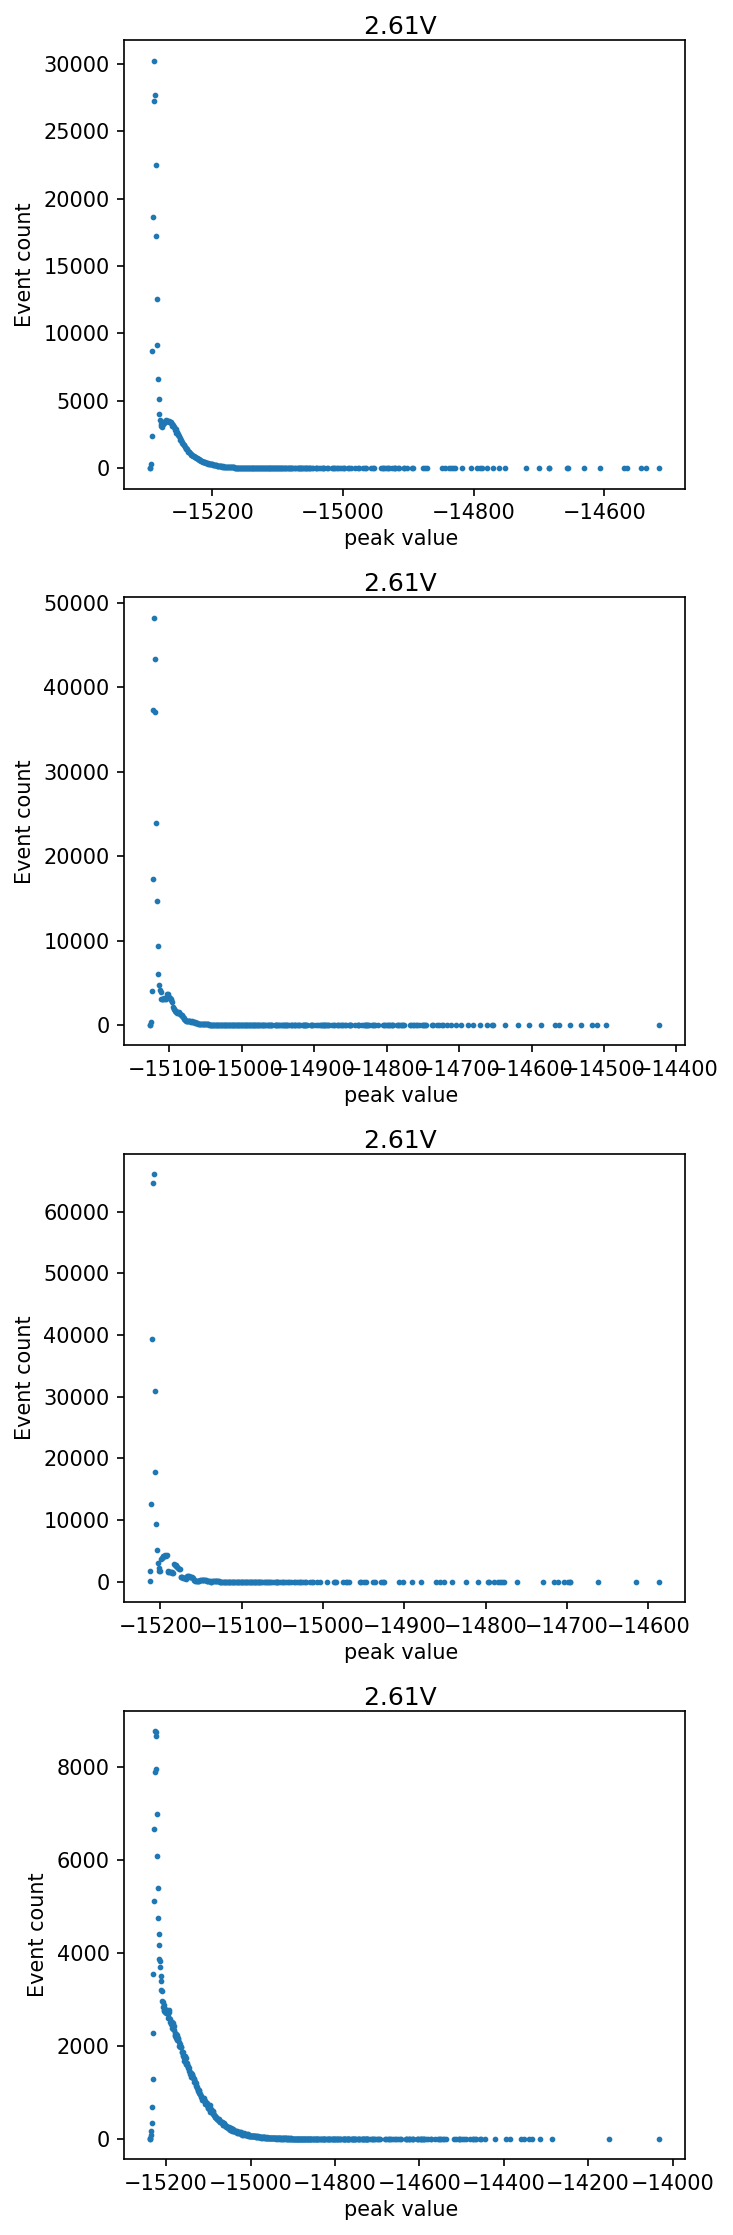

In [67]:
fig, ax = plt.subplots(4, 1, figsize=(6,15), dpi=150)
for k, d in data.items():
    d.get_peak_distribution()
    plot_pcount(d, ax[k-1], f'2.61V ')
plt.tight_layout()
plt.show()

##### Decode Raw File & Write to Processed File

In [64]:
# !!!! Execute This First !!!!!
id_range = list(range(252, 260, 2)) + list(range(260, 267))
ch_list = [1,2,3,4]
xlim_set = dict(zip(ch_list,[15, 10, 10 , 20]))

In [ ]:
# Decode and write
for i in tqdm.tqdm(id_range):
    data = analyse_raw_data(f'../../data/850/{i}_850_0710V_raw_b0_seg0.bin')
    title = f"{i}_850"
    open(f'0710/raw_{title}.txt', 'w').close()
    open(f'0710/dist_{title}.txt', 'w').close()
    open(f'0710/peak_{title}.txt', 'w').close()
    for d in data.values():
        save_raw_to_file(d,f'0710/raw_{title}.txt')
        save_dist_to_file(d,f'0710/dist_{title}.txt')
        save_peak_to_file(d,f'0710/peak_{title}.txt')

##### Get from Processed File

### Electron Count Analysis

##### Plot Distribution of election count

##### Curve Fit

##### Fit Parameter Analysis

### Peak Analysis

##### Plot Distribution of peak value

##### Curve Fit